In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
import random


df = pd.read_excel("/Users/samuelescarfone/Desktop/Dat 300/project1/Predicting-Credit-Card-Defaults/data/default of credit card clients.xls", header=1)
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


| Column | Description |
|---------|-------------|
| **ID** | Unique client identifier (not useful for modeling). |
| **LIMIT_BAL** | Credit limit (amount the client can borrow). |
| **SEX** | Gender (1 = male, 2 = female). |
| **EDUCATION** | Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others). |
| **MARRIAGE** | Marital status (1 = married, 2 = single, 3 = others). |
| **AGE** | Age of the client in years. |
| **PAY_0** | Repayment status in September 2005 (−1 = paid duly, 1 = 1-month delay, 2 = 2-month delay, … 9 = 9+ months delay). |
| **PAY_2** | Repayment status in August 2005 (same coding as PAY_0). |
| **PAY_3** | Repayment status in July 2005. |
| **PAY_4** | Repayment status in June 2005. |
| **PAY_5** | Repayment status in May 2005. |
| **PAY_6** | Repayment status in April 2005. |
| **BILL_AMT1** | Bill statement amount in September 2005. |
| **BILL_AMT2** | Bill statement amount in August 2005. |
| **BILL_AMT3** | Bill statement amount in July 2005. |
| **BILL_AMT4** | Bill statement amount in June 2005. |
| **BILL_AMT5** | Bill statement amount in May 2005. |
| **BILL_AMT6** | Bill statement amount in April 2005. |
| **PAY_AMT1** | Amount paid in September 2005. |
| **PAY_AMT2** | Amount paid in August 2005. |
| **PAY_AMT3** | Amount paid in July 2005. |
| **PAY_AMT4** | Amount paid in June 2005. |
| **PAY_AMT5** | Amount paid in May 2005. |
| **PAY_AMT6** | Amount paid in April 2005. |
| **default payment next month** | Target variable (1 = defaulted, 0 = did not default). |


In [86]:
df.isnull().sum()


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [87]:
df.describe()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [88]:

df.drop(columns=['ID'], axis=1, inplace=True)
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


<Axes: xlabel='LIMIT_BAL', ylabel='AGE'>

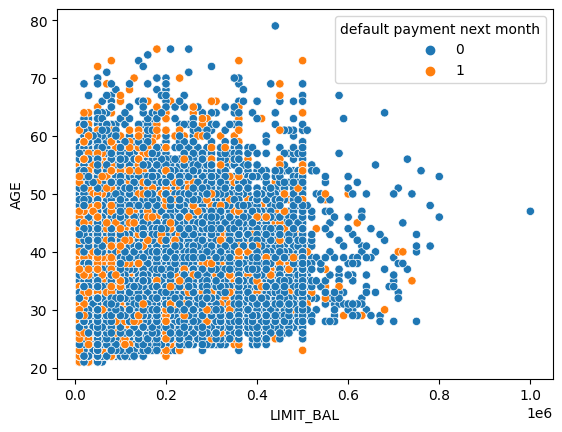

In [89]:
sns.scatterplot(x=df['LIMIT_BAL'],y=df['AGE'], hue=df['default payment next month'])

In [90]:
set.seed(123)
tr = sample( x=1:506, size=400, replace=FALSE)


In [95]:
'1'.isalpha()

False